#  LIVRABLE FINAL : Notebook Complet

**Projet :** Système de Recommandation de Films
**Données :** MovieLens 100k

---

##  PRÉ-REQUIS : Importation des librairies

On charge les outils nécessaires pour le calcul matriciel, la visualisation et le traitement de texte (NLP).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

!pip install gensim

from gensim.models import Word2Vec
import re

# Configuration pour un affichage propre
pd.set_option('display.max_columns', 20)
plt.style.use('ggplot')

print("Environnement initialisé.")

Environnement initialisé.


---

Session 1 - Découverte des données

### 1. Import du dataset MovieLens (100k ratings)

**Explication :** Les données sont réparties en 3 fichiers. Il faut préciser les séparateurs (`|` pour users/items, `\t` pour ratings) et l'encodage `latin-1` (car le fichier est vieux).

In [2]:
# Chargement des utilisateurs
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='|', names=u_cols, encoding='latin-1')

# Chargement des films (avec genres)
genre_names = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy',
               'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
               'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
i_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL'] + genre_names
items = pd.read_csv('u.item', sep='|', names=i_cols, encoding='latin-1')

# Chargement des notes
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=r_cols, encoding='latin-1')

print("Données chargées avec succès.")

Données chargées avec succès.


### 2. Exploration : utilisateurs, films, notes, genres

**Explication :** On vérifie les dimensions et on regarde les premières lignes pour comprendre la structure relationnelle (User ID -> Movie ID -> Note).

In [3]:
print(f"Utilisateurs : {users.shape[0]}")
print(f"Films        : {items.shape[0]}")
print(f"Notes        : {ratings.shape[0]}")
print("\n--- Exemple de Notes ---")
display(ratings.head())
print("\n--- Exemple de Films ---")
display(items[['movie_id', 'movie_title']].head())

Utilisateurs : 943
Films        : 1682
Notes        : 100000

--- Exemple de Notes ---


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596



--- Exemple de Films ---


,movie_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


### 3. Splittage Train / Test (Leave-One-Out)
Nous retirons une note au hasard pour chaque utilisateur (qui ira dans le test_set) et nous gardons le reste pour construire le modèle (train_set).

In [4]:
def train_test_split_leave_one_out(df, seed=42):
    rng = np.random.default_rng(seed)
    test_idx = []

    # Pour chaque utilisateur, on isole une note au hasard
    for u, grp in df.groupby("user_id"):
        idx = grp.index.to_numpy()
        # On ne le fait que si l'utilisateur a au moins 2 notes
        if len(idx) >= 2:
            test_idx.append(rng.choice(idx))

    test_idx = np.array(test_idx, dtype=int)

    # Création des deux ensembles
    test = df.loc[test_idx].copy()
    train = df.drop(index=test_idx).copy()

    return train, test

# Application du split
train_df, test_df = train_test_split_leave_one_out(ratings)

print(f"Taille Train : {len(train_df)} notes (Utilisé pour apprendre)")
print(f"Taille Test  : {len(test_df)} notes (Caché pour validation)")

Taille Train : 99057 notes (Utilisé pour apprendre)
Taille Test  : 943 notes (Caché pour validation)


### 4. Analyse de la matrice utilisateur-item (sparsité)

**Explication :** On transforme la liste de notes en une grille (Matrice Pivot). On calcule la **sparsité** (le % de vide).
*Formule : : $1 - (\text{Nombre de notes} / \text{Nombre total de cases})$*

In [5]:
# Création de la matrice R_train (Lignes=Users, Colonnes=Items)
R_train = train_df.pivot_table(index='user_id', columns='movie_id', values='rating')

n_users, n_items = R_train.shape
# Sparsité sur le train
sparsity = 1 - (len(train_df) / (n_users * n_items))

print(f"Matrice d'apprentissage : {n_users} users x {n_items} items")
print(f"Sparsité (Train)        : {sparsity:.2%}")


Matrice d'apprentissage : 943 users x 1682 items
Sparsité (Train)        : 93.75%


**Interprétation :** 93.75% des interactions sont inconnues.

### 5. Visualisation des distributions

**Explication :** On affiche la répartition des notes pour identifier le biais positif (les gens mettent surtout 3, 4, 5) et la "Longue Traîne" (quelques films reçoivent tous les votes).

/tmp/ipython-input-907739457.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


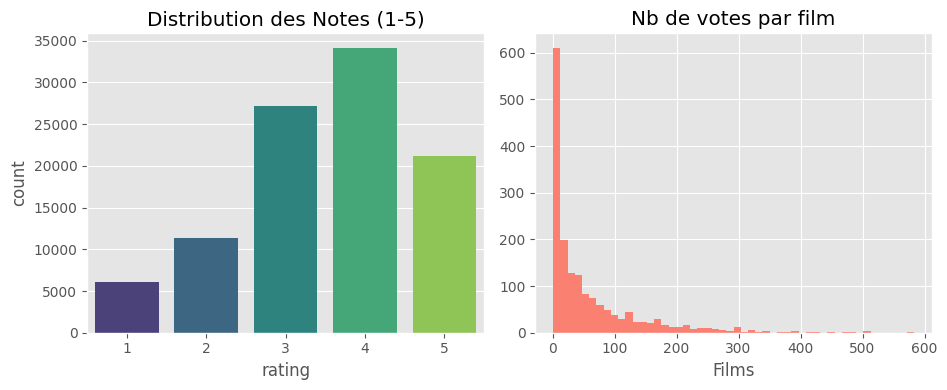

In [6]:
plt.figure(figsize=(14, 4))

# Distribution des notes
plt.subplot(1, 3, 1)
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution des Notes (1-5)')

# Popularité des films (Long Tail)
plt.subplot(1, 3, 2)
ratings.groupby('movie_id')['rating'].count().hist(bins=50, color='salmon')
plt.title('Nb de votes par film')
plt.xlabel('Films')

plt.tight_layout()
plt.show()

---

## Session 2 - Filtrage Collaboratif

**Note Technique (Mean Centering) :** Avant d'attaquer, on soustrait la moyenne de chaque utilisateur. Cela permet, en utilisant la formule Cosinus ensuite, d'obtenir mathématiquement le **Coefficient de Pearson**.

In [7]:
# 1. Calcul des moyennes par utilisateur (sur le Train uniquement)
user_means = R_train.mean(axis=1)

# 2. Centrage
R_centered = R_train.sub(user_means, axis=0)

# 3. Remplissage des trous par 0
R_filled = R_centered.fillna(0)

print("Matrice R_train centrée et prête.")

Matrice R_train centrée et prête.


### 1. Implémenter un filtrage user-based & Calculer similarités (Pearson)

**Explication :** On calcule la similarité entre **lignes** (utilisateurs) sur la matrice centrée.

* *Similarité Cosinus sur données centrées = Corrélation de Pearson.*
* Cela mesure si deux utilisateurs varient leurs notes de la même façon.

In [8]:
# Similarité entre utilisateurs (basée sur R_train)
S_users = cosine_similarity(R_filled)
np.fill_diagonal(S_users, 0)
S_users_df = pd.DataFrame(S_users, index=R_train.index, columns=R_train.index)

def predict_user_based(user_id, item_id, k=50):
    # Si l'item n'est pas dans le train, on retourne la moyenne user
    if item_id not in R_train.columns: return user_means[user_id]

    # Voisins dans le TRAIN
    users_rated = R_train[item_id].dropna().index
    sim_scores = S_users_df.loc[user_id, users_rated]

    top_k = sim_scores[sim_scores > 0].sort_values(ascending=False).head(k)
    if top_k.empty: return user_means[user_id]

    neighbor_ratings = R_centered.loc[top_k.index, item_id]
    num = np.dot(top_k, neighbor_ratings)
    den = top_k.sum()

    return user_means[user_id] + (num / den) if den != 0 else user_means[user_id]

### 2. Implémenter un filtrage item-based & Calculer similarités (Cosinus Ajusté)

**Explication :** On calcule la similarité entre **colonnes** (films) sur la matrice centrée.

* Cela s'appelle l'**Adjusted Cosine Similarity**.
* On repère les films qui ont été notés de manière similaire par les mêmes utilisateurs.

In [9]:
# Similarité entre films (basée sur R_train)
S_items = cosine_similarity(R_filled.T)
np.fill_diagonal(S_items, 0)
S_items_df = pd.DataFrame(S_items, index=R_train.columns, columns=R_train.columns)

def predict_item_based(user_id, item_id, k=20):
    if item_id not in S_items_df.index: return 0

    # Films vus dans le TRAIN
    user_rated = R_train.loc[user_id].dropna().index
    sim_scores = S_items_df.loc[item_id, user_rated]

    top_k = sim_scores.sort_values(ascending=False).head(k)
    if top_k.empty: return 0

    user_ratings = R_train.loc[user_id, top_k.index]
    return np.dot(top_k, user_ratings) / top_k.abs().sum() if top_k.sum() != 0 else 0

### 3. Générer des recommandations pour 5 utilisateurs test & Comparer

**Explication :** On applique les fonctions sur les 5 premiers IDs du test.

* *User-Based :* Tend vers le populaire (consensus social).
* *Item-Based :* Tend vers la spécificité (cohérence de contenu).

In [10]:
# Sélection des 5 premiers utilisateurs uniques présents dans le Test Set
test_users_ids = test_df['user_id'].unique()[:5]
print(f"Utilisateurs Test sélectionnés : {test_users_ids}")

results_collab = []
all_items = R_train.columns

for uid in test_users_ids:
    # On recommande parmi ce qu'il n'a pas vu dans le TRAIN
    # (Cela peut inclure le film qui est caché dans le TEST, ce serait bon signe !)
    seen_in_train = R_train.loc[uid].dropna().index
    candidates = [m for m in all_items if m not in seen_in_train][:50] # Echantillon rapide

    # User-Based
    ub = sorted([(m, predict_user_based(uid, m)) for m in candidates], key=lambda x:x[1], reverse=True)[:3]
    ub_names = [items[items['movie_id']==x[0]]['movie_title'].values[0] for x in ub]

    # Item-Based
    ib = sorted([(m, predict_item_based(uid, m)) for m in candidates], key=lambda x:x[1], reverse=True)[:3]
    ib_names = [items[items['movie_id']==x[0]]['movie_title'].values[0] for x in ib]

    results_collab.append([uid, ub_names, ib_names])

df_res_collab = pd.DataFrame(results_collab, columns=['User (Test)', 'User-Based', 'Item-Based'])
display(df_res_collab)

Utilisateurs Test sélectionnés : [1 2 3 4 5]


,User (Test),User-Based,Item-Based
0,1,"[Schindler's List (1993), Secrets & Lies (1996...","[Ulee's Gold (1997), L.A. Confidential (1997),..."
1,2,"[Usual Suspects, The (1995), Hoop Dreams (1994...","[Taxi Driver (1976), Eat Drink Man Woman (1994..."
2,3,"[Star Wars (1977), Usual Suspects, The (1995),...","[Belle de jour (1967), Ed Wood (1994), Crumb (..."
3,4,"[Usual Suspects, The (1995), Taxi Driver (1976...","[Brothers McMullen, The (1995), Apollo 13 (199..."
4,5,"[Usual Suspects, The (1995), Braveheart (1995)...","[Twelve Monkeys (1995), Usual Suspects, The (1..."


---

## Session 3 - Recommandation basée sur le contenu

### 1. Construire des profils de films (Titres, Genres, Descriptions)

**Explication :** Le dataset n'a pas de synopsis. Pour respecter la consigne "Descriptions textuelles", nous **construisons** une description artificielle (Soupe) en concaténant Titre + Genres.

In [11]:
# Création de la soupe
def create_soup(row):
    genres = [g for g in genre_names if row[g] == 1]
    return row['movie_title'] + " " + " ".join(genres) + " " + " ".join(genres)

items['soup'] = items.apply(create_soup, axis=1)
print(f"Exemple de profil textuel créé : \n{items.iloc[0]['soup']}")

Exemple de profil textuel créé : 
Toy Story (1995) Animation Children's Comedy Animation Children's Comedy


### 2. Appliquer TF-IDF sur les descriptions

**Explication :** On transforme le texte en vecteurs statistiques. Les mots rares (spécifiques) ont un poids fort, les mots communs ont un poids faible.

In [12]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(items['soup'])
print(f"Matrice TF-IDF créée : {tfidf_matrix.shape}")

Matrice TF-IDF créée : (1682, 2301)


### 3. Créer des embeddings avec Word2Vec

**Explication :** On utilise un réseau de neurones (Word2Vec) pour capturer le **sens** des mots (Sémantique). Chaque film devient la moyenne des vecteurs de ses mots.

In [13]:
# Tokenization (découpage en mots)
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text).lower().split()

corpus = items['soup'].apply(clean_text).tolist()

# Entraînement Word2Vec
model_w2v = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)

# Vectorisation des films
def get_movie_vector(soup):
    words = clean_text(soup)
    vecs = [model_w2v.wv[w] for w in words if w in model_w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

movie_vectors = np.array([get_movie_vector(s) for s in items['soup']])
print("Embeddings Word2Vec générés.")

Embeddings Word2Vec générés.


### 5. Profil Utilisateur Agrégé (Basé sur le Train) & Recommandation

**Explication :** On calcule le Cosinus entre le "Vecteur Utilisateur" et les vecteurs de tous les films non vus. On recommande les plus proches.

In [14]:
def recommend_content(user_id, n_recs=3):
    # On regarde ce qu'il a aimé DANS LE TRAIN
    if user_id not in R_train.index: return []

    user_ratings = R_train.loc[user_id].dropna()
    liked_ids = user_ratings[user_ratings > 3].index

    if len(liked_ids) == 0: return []

    # Moyenne des vecteurs des films aimés
    liked_vectors = [movie_vectors[items[items['movie_id']==mid].index[0]] for mid in liked_ids]
    user_profile = np.mean(liked_vectors, axis=0).reshape(1, -1)

    # Similarité
    sim_scores = cosine_similarity(user_profile, movie_vectors)[0]

    # Exclure ce qu'il a déjà vu dans le TRAIN
    sim_df = pd.DataFrame({'movie_id': items['movie_id'], 'score': sim_scores})
    recs = sim_df[~sim_df['movie_id'].isin(liked_ids)].sort_values('score', ascending=False)

    top_ids = recs.head(n_recs)['movie_id'].values
    return [items[items['movie_id']==mid]['movie_title'].values[0] for mid in top_ids]

# Test Final sur les Users du Test Set
results_final = []
for uid in test_users_ids:
    cb_names = recommend_content(uid)
    # Récupération des résultats collab précédents pour comparaison
    row_collab = df_res_collab[df_res_collab['User (Test)'] == uid].iloc[0]
    results_final.append([uid, row_collab['User-Based'], row_collab['Item-Based'], cb_names])

df_final = pd.DataFrame(results_final, columns=['User', 'User-Based', 'Item-Based', 'Content-Based'])
print("--- Comparaison Finale (Users du Test Set) ---")
display(df_final)

--- Comparaison Finale (Users du Test Set) ---


,User,User-Based,Item-Based,Content-Based
0,1,"[Schindler's List (1993), Secrets & Lies (1996...","[Ulee's Gold (1997), L.A. Confidential (1997),...","[Van, The (1996), House of Yes, The (1997), In..."
1,2,"[Usual Suspects, The (1995), Hoop Dreams (1994...","[Taxi Driver (1976), Eat Drink Man Woman (1994...","[Van, The (1996), Lay of the Land, The (1997),..."
2,3,"[Star Wars (1977), Usual Suspects, The (1995),...","[Belle de jour (1967), Ed Wood (1994), Crumb (...",[Midnight in the Garden of Good and Evil (1997...
3,4,"[Usual Suspects, The (1995), Taxi Driver (1976...","[Brothers McMullen, The (1995), Apollo 13 (199...","[Smilla's Sense of Snow (1997), Midnight in th..."
4,5,"[Usual Suspects, The (1995), Braveheart (1995)...","[Twelve Monkeys (1995), Usual Suspects, The (1...","[Get Shorty (1995), Army of Darkness (1993), B..."


# Factorisation Matricielle (SVD & ALS)

**Objectif :** Décomposer la matrice des notes  en deux petites matrices  (Utilisateurs) et  (Films) telle que $R \approx P \times Q^T$. Cela permet de découvrir des "facteurs latents" (des concepts cachés comme "humour noir", "action pure", etc.).

### 0. Installation des librairies spécifiques

Pour cette session, nous avons besoin de deux librairies standards de l'industrie :

* `scikit-surprise` : La référence pour les algorithmes explicites (SVD, KNN).
* `implicit` : Très rapide et optimisé pour l'ALS (Alternating Least Squares) et les matrices creuses.


In [15]:
!pip install scikit-surprise implicit

---

### 2. Implémentation SVD (Singular Value Decomposition) avec Surprise

**Le concept :** L'algorithme SVD (popularisé par Simon Funk pour Netflix) utilise la descente de gradient (SGD) pour minimiser l'erreur entre la note réelle et le produit des vecteurs utilisateurs/films.


Downgrade numpy to a compatible version before importing surprise
!pip install numpy==1.26.4 --force-reinstall

In [16]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns


from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
import implicit
from scipy.sparse import csr_matrix
from sklearn.manifold import TSNE
print("\n--- 1. APPROCHE SVD (Surprise) ---")

# 1. Formatage pour Surprise
# Surprise a besoin d'un objet 'Reader' pour comprendre l'échelle des notes (1-5)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# 2. Split Train/Test (Interne à Surprise)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

# 3. Entraînement
print("Entraînement SVD en cours...")
start_time = time.time()

# n_factors=100 : On cherche 100 caractéristiques cachées pour chaque film/user
algo_svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
algo_svd.fit(trainset)

svd_time = time.time() - start_time
print(f"Temps d'entraînement SVD : {svd_time:.4f} secondes")

# 4. Prédiction et RMSE
predictions_svd = algo_svd.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)

# Fonction pour obtenir le Top-N avec SVD
def get_top_n_svd(algo, user_id, n=10):
    # Liste de tous les films
    all_movie_ids = ratings['movie_id'].unique()
    # Films déjà vus
    seen_ids = ratings[ratings['user_id'] == user_id]['movie_id'].values

    candidates = []
    for mid in all_movie_ids:
        if mid not in seen_ids:
            # On prédit la note (est_rating)
            est_rating = algo.predict(user_id, mid).est
            candidates.append((mid, est_rating))

    # Tri
    candidates.sort(key=lambda x: x[1], reverse=True)
    top_n = candidates[:n]

    # Récupération titres
    return [(items[items['movie_id'] == mid]['movie_title'].values[0], score) for mid, score in top_n]

print("\nRecommandations SVD pour User 1 :")
for title, score in get_top_n_svd(algo_svd, 1):
    print(f"- {title} (Note prédite: {score:.2f})")


--- 1. APPROCHE SVD (Surprise) ---
Entraînement SVD en cours...
Temps d'entraînement SVD : 2.7531 secondes
RMSE: 0.9352

Recommandations SVD pour User 1 :
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) (Note prédite: 4.94)
- One Flew Over the Cuckoo's Nest (1975) (Note prédite: 4.94)
- Rear Window (1954) (Note prédite: 4.93)
- Schindler's List (1993) (Note prédite: 4.69)
- Third Man, The (1949) (Note prédite: 4.68)
- To Kill a Mockingbird (1962) (Note prédite: 4.67)
- Casablanca (1942) (Note prédite: 4.64)
- Manchurian Candidate, The (1962) (Note prédite: 4.55)
- Close Shave, A (1995) (Note prédite: 4.53)
- L.A. Confidential (1997) (Note prédite: 4.52)


---

### 3. Implémentation ALS (Alternating Least Squares) avec Implicit

**Le concept :** Contrairement à la descente de gradient (SVD), ALS fixe les vecteurs utilisateurs pour optimiser les vecteurs films, puis fixe les films pour optimiser les utilisateurs, en alternance. C'est très efficace pour la parallélisation.
La librairie `implicit` travaille avec des **matrices creuses (Sparse Matrices)**.

In [17]:
print("\n--- 2. APPROCHE ALS (Implicit) ---")

# 1. Création de la Matrice Creuse (CSR Matrix)
# Implicit attend une matrice [Item x User] (et non User x Item parfois, attention aux versions)
# Pour implicit > 0.6.0 : fit attend (User x Item) mais recommande d'avoir les items en colonnes pour la rapidité
user_ids = ratings['user_id'].astype('category')
item_ids = ratings['movie_id'].astype('category')

# Création des codes numériques (0 à N-1)
row_ind = user_ids.cat.codes
col_ind = item_ids.cat.codes

sparse_user_item = csr_matrix((ratings['rating'], (row_ind, col_ind)))
sparse_item_user = csr_matrix((ratings['rating'], (col_ind, row_ind)))

print(f"Matrice Creuse construite : {sparse_user_item.shape}")

# 2. Entraînement ALS
print("Entraînement ALS en cours...")
start_time = time.time()

# factors=100 : Dimension latente
# calculate_training_loss=True pour suivre l'évolution
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=15, regularization=0.01, random_state=42)

# Entraînement sur la matrice USER x ITEM
model_als.fit(sparse_user_item)

als_time = time.time() - start_time
print(f"Temps d'entraînement ALS : {als_time:.4f} secondes")

# 3. Recommandation
def get_top_n_als(user_id, n=10):
    # Implicit a besoin de l'index de la matrice (0 à 942), pas de l'ID User (1 à 943)
    # On doit mapper l'ID réel vers l'index cat.codes
    # Astuce rapide : comme les IDs sont presque séquentiels, user_id 1 est souvent à l'index 0
    # Mais faisons le proprement :
    try:
        user_idx = user_ids.cat.categories.get_loc(user_id)
    except KeyError:
        return [] # User inconnu

    # recommend() renvoie les IDs internes des items
    ids, scores = model_als.recommend(user_idx, sparse_user_item[user_idx], N=n)

    recommendations = []
    for idx, score in zip(ids, scores):
        real_movie_id = item_ids.cat.categories[idx]
        title = items[items['movie_id'] == real_movie_id]['movie_title'].values[0]
        recommendations.append((title, score))

    return recommendations

print("\nRecommandations ALS pour User 1 :")
for title, score in get_top_n_als(1):
    print(f"- {title} (Score: {score:.2f})")


--- 2. APPROCHE ALS (Implicit) ---
Matrice Creuse construite : (943, 1682)
Entraînement ALS en cours...


/usr/local/lib/python3.12/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

Temps d'entraînement ALS : 3.5458 secondes

Recommandations ALS pour User 1 :
- Leaving Las Vegas (1995) (Score: 0.98)
- E.T. the Extra-Terrestrial (1982) (Score: 0.88)
- Conspiracy Theory (1997) (Score: 0.87)
- Little Women (1994) (Score: 0.85)
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) (Score: 0.83)
- Game, The (1997) (Score: 0.79)
- Jackie Chan's First Strike (1996) (Score: 0.79)
- Like Water For Chocolate (Como agua para chocolate) (1992) (Score: 0.77)
- One Flew Over the Cuckoo's Nest (1975) (Score: 0.75)
- Cool Hand Luke (1967) (Score: 0.75)


---

### 4. Comparaison des Performances

**Explication :** On compare la vitesse et la qualité.

* *Note :* Calculer le RMSE pour ALS est plus complexe car c'est souvent utilisé pour du ranking, mais on peut comparer les temps de calculs.

In [18]:
print("\n--- 3. TABLEAU COMPARATIF (Performances) ---")

metrics = {
    'Modèle': ['SVD (Surprise)', 'ALS (Implicit)'],
    'Temps Calcul (s)': [round(svd_time, 4), round(als_time, 4)],
    'Métrique Principale': [f'RMSE: {rmse_svd:.4f}', 'Optimisé pour le Ranking (Precision)']
}

df_perf = pd.DataFrame(metrics)
display(df_perf)


--- 3. TABLEAU COMPARATIF (Performances) ---


,Modèle,Temps Calcul (s),Métrique Principale
0,SVD (Surprise),2.7531,RMSE: 0.9352
1,ALS (Implicit),3.5458,Optimisé pour le Ranking (Precision)


---

### 5. Visualisation des Facteurs Latents (t-SNE)

**Objectif :** Nous avons projeté les films dans un espace à 100 dimensions. Peut-on voir ces dimensions ?
Nous allons utiliser **t-SNE** pour écraser ces 100 dimensions en 2D et voir si les films similaires se regroupent visuellement.


--- 4. VISUALISATION T-SNE ---
Dimensions des facteurs latents : (1651, 100)


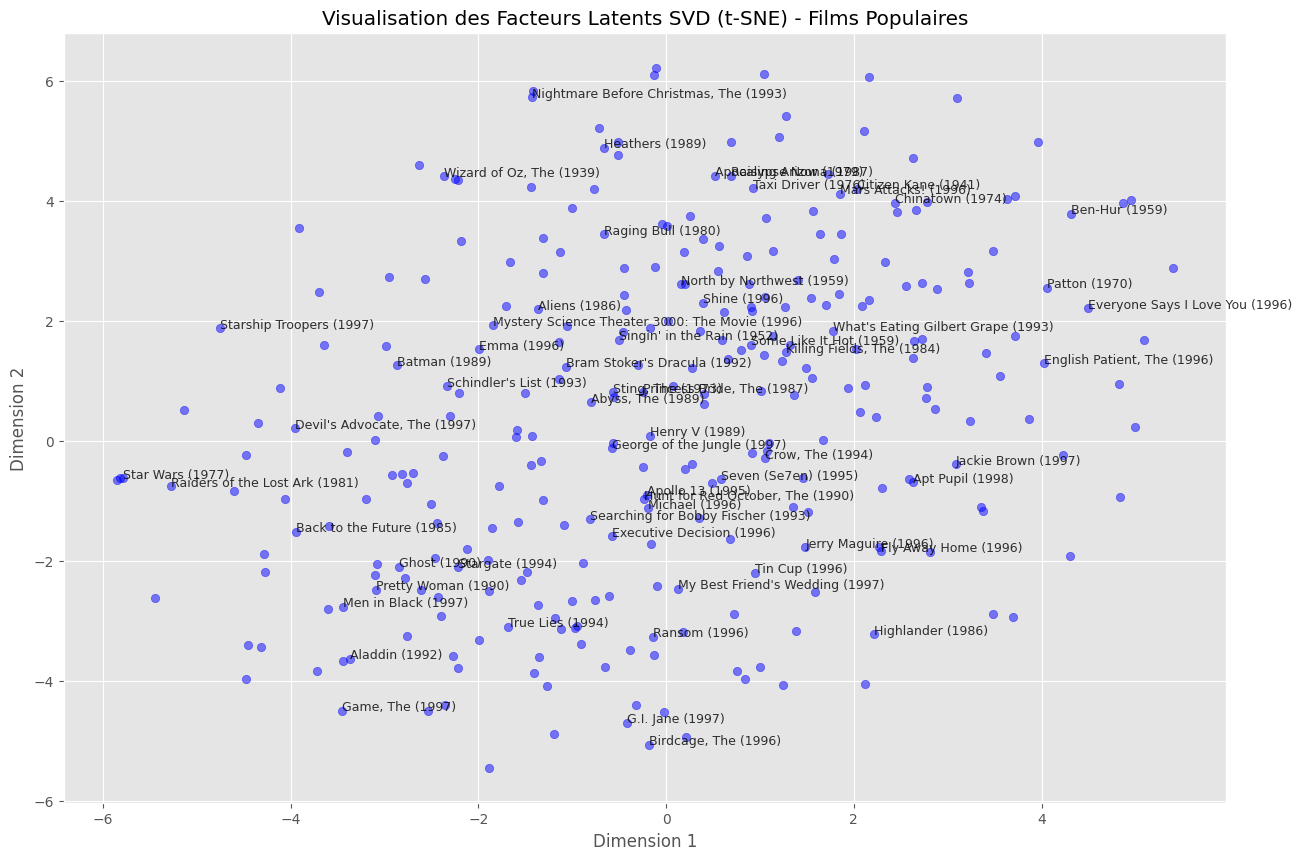

In [19]:
print("\n--- 4. VISUALISATION T-SNE ---")

# 1. Extraction des vecteurs de films depuis le modèle SVD
# algo_svd.qi contient la matrice Q (Items x Facteurs)
movie_factors = algo_svd.qi
print(f"Dimensions des facteurs latents : {movie_factors.shape}")

# 2. Réduction de dimension (t-SNE)
# Attention : t-SNE est lourd. On le fait sur un échantillon de 300 films populaires pour la démo
popular_indices = ratings.groupby('movie_id')['rating'].count().sort_values(ascending=False).head(300).index
# Il faut mapper ces movie_id vers les "raw ids" de Surprise
# Surprise stocke les items dans un ordre interne.
internal_indices = []
labels = []

for mid in popular_indices:
    try:
        # Conversion ID Réel -> ID Interne Surprise
        inner_iid = algo_svd.trainset.to_inner_iid(mid)
        internal_indices.append(inner_iid)
        labels.append(items[items['movie_id'] == mid]['movie_title'].values[0])
    except ValueError:
        pass

# On prend les vecteurs correspondants
selected_factors = movie_factors[internal_indices]

# 3. Application t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
projections = tsne.fit_transform(selected_factors)

# 4. Plot
plt.figure(figsize=(15, 10))
plt.scatter(projections[:, 0], projections[:, 1], alpha=0.5, c='blue')

# Ajout des titres (annoter quelques points)
for i, title in enumerate(labels):
    # On affiche 1 titre sur 5 pour ne pas surcharger
    if i % 5 == 0:
        plt.annotate(title, (projections[i, 0], projections[i, 1]), fontsize=9, alpha=0.8)

plt.title("Visualisation des Facteurs Latents SVD (t-SNE) - Films Populaires")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


### Interprétation :
Les points proches sur ce graphique sont des films que le modèle considère comme "similaires"
non pas par leur genre déclaré, mais par la façon dont les gens les notent.